# Stock Price Prediction Model

## Dependencies

### Library Installation (if needed)

In [1]:
#! pip install -Ur requirements.txt

### Importing Required Libraries

In [2]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import pickle
import gradio as gr
import ast
import warnings
from methods.model_methods import *
from datetime import datetime
from tqdm import tqdm
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SyntaxWarning)

/home/victorvj/.local/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
Stock("AAPL").get_df_financials()

,Ticker,Name,Date,Earn Index,Sector,Industry,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,NormalizedEBITDA,...,InterestExpenseNonOperating,InterestIncomeNonOperating,OperatingIncome,OperatingExpense,ResearchAndDevelopment,SellingGeneralAndAdministration,GrossProfit,CostOfRevenue,TotalRevenue,OperatingRevenue
0,AAPL,Apple Inc.,2025-06-30,0,Technology,Consumer Electronics,NaN,0.0,0.163997,3.103200e+10,...,NaN,NaN,2.820200e+10,1.551600e+10,8.866000e+09,6.650000e+09,4.371800e+10,5.031800e+10,9.403600e+10,9.403600e+10
0,AAPL,Apple Inc.,2025-03-31,1,Technology,Consumer Electronics,-0.075141,0.0,0.155000,3.225000e+10,...,NaN,NaN,2.958900e+10,1.527800e+10,8.550000e+09,6.728000e+09,4.486700e+10,5.049200e+10,9.535900e+10,9.535900e+10
0,AAPL,Apple Inc.,2024-12-31,2,Technology,Consumer Electronics,-0.107757,0.0,0.147000,4.591200e+10,...,NaN,NaN,4.283200e+10,1.544300e+10,8.268000e+09,7.175000e+09,5.827500e+10,6.602500e+10,1.243000e+11,1.243000e+11
0,AAPL,Apple Inc.,2024-09-30,3,Technology,Consumer Electronics,0.083594,0.0,0.241000,1.346610e+11,...,NaN,NaN,1.232160e+11,5.746700e+10,3.137000e+10,2.609700e+10,1.806830e+11,2.103520e+11,3.910350e+11,3.910350e+11
0,AAPL,Apple Inc.,2024-06-30,4,Technology,Consumer Electronics,0.082773,0.0,0.159000,2.820200e+10,...,NaN,NaN,2.535200e+10,1.432600e+10,8.006000e+09,6.320000e+09,3.967800e+10,4.609900e+10,8.577700e+10,8.577700e+10
0,AAPL,Apple Inc.,2023-09-30,5,Technology,Consumer Electronics,0.126007,0.0,0.147000,1.258200e+11,...,3.933000e+09,3.750000e+09,1.143010e+11,5.484700e+10,2.991500e+10,2.493200e+10,1.691480e+11,2.141370e+11,3.832850e+11,3.832850e+11
0,AAPL,Apple Inc.,2022-09-30,6,Technology,Consumer Electronics,-0.058281,0.0,0.162000,1.305410e+11,...,2.931000e+09,2.825000e+09,1.194370e+11,5.134500e+10,2.625100e+10,2.509400e+10,1.707820e+11,2.235460e+11,3.943280e+11,3.943280e+11
0,AAPL,Apple Inc.,2021-09-30,7,Technology,Consumer Electronics,0.261202,0.0,0.133000,1.231360e+11,...,2.645000e+09,2.843000e+09,1.089490e+11,4.388700e+10,2.191400e+10,2.197300e+10,1.528360e+11,2.129810e+11,3.658170e+11,3.658170e+11


### Variables

In [4]:
symbol_list = input("Symbols: ('simple', 'filtered' or 'all')") # 'simple' or 'all'. simple are the tickers from the screener notebook and all are all of the tickers in 'filtered_tickers'. You may also an 'Int' to get a % amount of random tickers from 'all'
if symbol_list:
    build_new_dataset = True
else:
    build_new_dataset = False
    symbol_list = 'filtered'
minimum_feature_threshold = 0.6
outlier = 3
iterations = input("Iterations eg. '10', '20', '30'")
if iterations:
    iterations = ast.literal_eval(iterations)
    train_new_model = True
    search_params = {
            "hidden_layer_amount": Integer(2, 10),
            "neuron_amount": Integer(20, 500),
            "warm_start": Categorical([False, True]),
            "activation": Categorical(['identity', 'logistic', 'tanh', 'relu']),
            "solver": Categorical(['sgd', 'adam', 'lbfgs']),
            "alpha": Real(0.000001, 1),
            "learning_rate_init": Real(0.00001, 0.1),
            "power_t": Real(0.0001, 100),
            "momentum": Real(0.0001, 100),
            "validation_fraction": Real(0.05, 0.20),
            "beta_1": Real(0.001, 10),
            "beta_2": Real(0.0001, 100),
            "epsilon": Real(0.0000000001, 0.000001),}
    cross_validations = 2  # will be set to 3 if not specified
    verticle_jobs = 1 #'-1' for max
else:
    train_new_model = False
if build_new_dataset or train_new_model:
    debugging = {'True': True, 'False': False}.get(input('Debug? (Bool)'))
else:
    debugging = False

In [5]:
symbols = pd.read_csv('../data/tickers/simple_tickers.csv')['Ticker'].tolist()
if symbol_list == 'filtered':
    symbols = symbols + pd.read_csv('../data/tickers/model_filtered_tickers.csv')['Ticker'].tolist()
elif symbol_list == 'all':
    symbols = symbols + pd.read_csv('../data/tickers/tickers.csv')['Ticker'].tolist()
elif symbol_list.isdigit():
    all_symbols = pd.read_csv('../data/tickers/tickers.csv')['Ticker'].tolist()
    num_symbols = max(1, round(len(all_symbols) * (int(symbol_list) / 100)))  
    symbols = symbols + pd.read_csv("../data/tickers/model_filtered_tickers.csv")["Ticker"].tolist()
    symbols = symbols + np.random.choice(all_symbols, num_symbols, replace=False).tolist()

symbols = pd.Series(symbols).unique()
symbols

array(['MATAS.CO', 'TRIFOR.CO', 'RHM.DE', ..., 'PETS', 'PTCT', 'WMT'],
      shape=(2036,), dtype=object)

## Data Preparation

#### Download annual financial data

In [6]:
if build_new_dataset:
    df = pd.DataFrame()
    filtered_pd = pd.read_csv("../data/tickers/model_filtered_tickers.csv")
    for symbol in tqdm(symbols, smoothing=0):
        ticker_df = pd.DataFrame()
        ticker = yf.Ticker(symbol)
        stock = Stock(symbol)
        try:
            ticker_df = Stock(symbol).get_df_financials()
            if ticker_df.isna().sum().sum() < round(29 * minimum_feature_threshold):
                if symbol not in filtered_pd["Ticker"].tolist():
                    filtered_pd = pd.concat([filtered_pd, pd.DataFrame([{"Ticker": symbol}])])
                imputer = SimpleImputer()
                for column in ticker_df.columns.drop(["Ticker", "Name", "Date", "3M Future Change", "Sector", "Industry"]):
                    if not ticker_df[column].isna().all():
                        ticker_df[column] = imputer.fit_transform(ticker_df[[column]])
            else:
                if symbol in filtered_pd["Ticker"].tolist():
                    filtered_pd = filtered_pd[filtered_pd["Ticker"] != symbol]
                    if debugging:
                        print(f"Removed {symbol} from filtered tickers. Datapoints: {ticker_df.isna().sum().sum()}, Needed: {round(29 * minimum_feature_threshold)}")
                continue
            df = pd.concat([df, ticker_df], ignore_index=True)
        except Exception as error:
            if symbol in filtered_pd["Ticker"].tolist():
                filtered_pd = filtered_pd[filtered_pd["Ticker"] != symbol]
                if debugging:
                    print(f"Removed {symbol} from filtered tickers because an exception was raised \n {error}")
            else:
                if debugging:
                    print(f"{symbol}: exception raised: {error}")
            continue
    filtered_pd.to_csv("../data/tickers/model_filtered_tickers.csv", index=False)
    df.to_csv("../data/model_results/earnings_data.csv", index=False)
else:
    df = pd.read_csv("../data/model_results/earnings_data.csv")

### Short visualisation

In [7]:
if debugging:
    display(df)

,Ticker,Name,Date,Earn Index,Sector,Industry,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,NormalizedEBITDA,...,SellingAndMarketingExpense,GeneralAndAdministrativeExpense,OtherGandA,OtherIncomeExpense,EarningsFromEquityInterest,GainOnSaleOfSecurity,RentExpenseSupplemental,AverageDilutionEarnings,RentAndLandingFees,EarningsFromEquityInterestNetOfTax
0,BAESY,BAE Systems PLC,2024-12-31,0.0,Industrials,Aerospace & Defense,NaN,-1.746998e+06,0.124786,3.986000e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BAESY,BAE Systems PLC,2023-12-31,1.0,Industrials,Aerospace & Defense,0.216240,-4.862339e+07,0.165950,3.740000e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BAESY,BAE Systems PLC,2022-12-31,2.0,Industrials,Aerospace & Defense,0.171293,7.744344e+07,0.158371,2.570000e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BAESY,BAE Systems PLC,2021-12-31,3.0,Industrials,Aerospace & Defense,0.257805,2.160000e+07,0.180000,3.005000e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CARL-B.CO,Carlsberg B A/S,2024-12-31,0.0,Consumer Defensive,Beverages - Brewers,NaN,-9.900000e+07,0.198000,1.629700e+10,...,1.924200e+10,4.381000e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,RDDT,"Reddit, Inc.",2025-06-30,0.0,Communication Services,Internet Content & Information,NaN,0.000000e+00,0.210000,7.164500e+07,...,1.206190e+08,6.878700e+07,68787000.0,21147000.0,NaN,NaN,NaN,NaN,NaN,NaN
92,RDDT,"Reddit, Inc.",2025-03-31,1.0,Communication Services,Internet Content & Information,0.435367,0.000000e+00,0.400000,7.866000e+06,...,9.068500e+07,6.941300e+07,69413000.0,20534000.0,NaN,NaN,NaN,NaN,NaN,NaN
93,RDDT,"Reddit, Inc.",2024-12-31,2.0,Communication Services,Internet Content & Information,-0.326664,0.000000e+00,0.001000,-5.449250e+08,...,3.505790e+08,4.514470e+08,451447000.0,75361000.0,NaN,NaN,NaN,NaN,NaN,NaN
94,RDDT,"Reddit, Inc.",2024-09-30,3.0,Communication Services,Internet Content & Information,1.511074,0.000000e+00,0.210000,1.082300e+07,...,7.451000e+07,6.565300e+07,65653000.0,22968000.0,NaN,NaN,NaN,NaN,NaN,NaN


### Impution and encoding

In [8]:
imputer = SimpleImputer()
scaler = StandardScaler()
for column in df.columns.drop(["Ticker", "Name", "Date", "Earn Index", "3M Future Change", "Sector", "Industry"]):
    df[column] = imputer.fit_transform(df[[column]])
    scaler.fit(df[[column]])
    df[column] = scaler.transform(df[[column]])

le = LabelEncoder()
for column in ["Ticker", "Sector", "Industry"]:
    df[column] = df[column].astype(str)
    le.fit(df[column])
    df[column] = le.transform(df[column])

### Splitting

In [9]:
pred_data = df.loc[df["Earn Index"] == 0].copy()
test_data  = df.loc[df["Earn Index"] == 1].copy()
train_data = df.loc[~df["Earn Index"].isin([0, 1])].copy()

pred_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
train_data.reset_index(drop=True, inplace=True)

if debugging:
    print('Prediction Data:')
    display(pred_data)
    print("Test Data:")
    display(test_data)
    print('Training Data:')
    display(train_data)

Prediction Data:


,Ticker,Name,Date,Earn Index,Sector,Industry,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,NormalizedEBITDA,...,SellingAndMarketingExpense,GeneralAndAdministrativeExpense,OtherGandA,OtherIncomeExpense,EarningsFromEquityInterest,GainOnSaleOfSecurity,RentExpenseSupplemental,AverageDilutionEarnings,RentAndLandingFees,EarningsFromEquityInterestNetOfTax
0,1,BAE Systems PLC,2024-12-31,0.0,6,0,NaN,-0.037415,-1.206157,-0.619508,...,9.749015e-17,-1.349201e-16,0.000000,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.000000,0.000000
1,2,Carlsberg B A/S,2024-12-31,0.0,2,3,NaN,-0.230544,0.037184,-0.263364,...,1.100643e+00,4.289678e-01,0.000000,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.000000,0.000000
2,8,ISS A/S,2024-12-31,0.0,6,13,NaN,-0.029577,0.071149,-0.572469,...,9.749015e-17,-1.349201e-16,0.000000,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.000000,0.000000
3,11,"Netflix, Inc.",2025-06-30,0.0,0,4,NaN,-0.033946,-0.947788,-0.511302,...,-7.934723e-01,-6.857872e-01,-1.444185,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.000000,0.000000
4,6,Equinor ASA,2025-06-30,0.0,3,10,NaN,0.003626,0.410794,-0.461411,...,9.749015e-17,-1.349201e-16,0.000000,-5.134093e-02,1.324789e-01,-0.173903,-3.191363e-16,0.000000,0.000000,0.000000
5,14,"Tesla, Inc.",2025-06-30,0.0,1,1,NaN,-0.033946,0.610540,-0.646064,...,9.749015e-17,-1.349201e-16,0.000000,2.549892e-02,2.565339e-17,0.000000,-1.332486e+00,-2.449487,0.000000,0.000000
6,5,Demant A/S,2024-12-31,0.0,5,8,NaN,0.020720,0.444759,-0.570531,...,1.810195e-01,-4.866520e-01,0.000000,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.000000,0.000000
7,13,Sydbank A/S,2025-03-31,0.0,4,2,NaN,-0.033946,0.905437,0.000000,...,-8.636263e-01,-7.229137e-01,0.000000,1.017780e-17,2.565339e-17,-0.160583,-3.191363e-16,0.000000,-1.414039,0.000000
8,4,Coloplast B A/S,2025-03-31,0.0,5,9,NaN,-0.098723,3.269421,-0.670162,...,-6.286091e-01,-7.257431e-01,0.000000,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.000000,0.000000
9,3,cBrain A/S,2024-12-31,0.0,7,11,NaN,-0.033946,0.858651,-0.731533,...,-8.645941e-01,-8.051819e-01,0.000000,1.017780e-17,2.565339e-17,0.000000,-2.546009e+00,0.000000,-2.637962,0.000000


Test Data:


,Ticker,Name,Date,Earn Index,Sector,Industry,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,NormalizedEBITDA,...,SellingAndMarketingExpense,GeneralAndAdministrativeExpense,OtherGandA,OtherIncomeExpense,EarningsFromEquityInterest,GainOnSaleOfSecurity,RentExpenseSupplemental,AverageDilutionEarnings,RentAndLandingFees,EarningsFromEquityInterestNetOfTax
0,1,BAE Systems PLC,2023-12-31,1.0,6,0,0.216240,-0.130504,-0.507098,-0.626624,...,9.749015e-17,-1.349201e-16,0.000000,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.000000,0.000000
1,2,Carlsberg B A/S,2023-12-31,1.0,2,3,0.154066,-0.155551,-0.115657,-0.290962,...,1.009969e+00,3.429516e-01,0.000000,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.000000,0.000000
2,8,ISS A/S,2023-12-31,1.0,6,13,-0.018735,-0.010896,0.393812,-0.603597,...,9.749015e-17,-1.349201e-16,0.000000,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.000000,0.000000
3,11,"Netflix, Inc.",2025-03-31,1.0,0,4,0.436018,-0.033946,-1.627080,-0.523606,...,-7.960172e-01,-6.913757e-01,-1.450724,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.000000,0.000000
4,6,Equinor ASA,2025-03-31,1.0,3,10,-0.034369,-0.030014,0.410794,-0.401586,...,9.749015e-17,-1.349201e-16,0.000000,-7.627119e-02,1.692057e-01,-0.200893,-3.191363e-16,0.000000,0.000000,0.000000
5,14,"Tesla, Inc.",2025-03-31,1.0,1,1,0.225729,-0.088080,1.599554,-0.670567,...,9.749015e-17,-1.349201e-16,0.000000,-1.565261e-01,2.565339e-17,0.000000,-1.273590e+00,-2.449487,0.000000,0.000000
6,5,Demant A/S,2023-12-31,1.0,5,8,0.177885,-0.033946,0.852333,-0.573713,...,1.102792e-01,-4.988188e-01,0.000000,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.000000,0.000000
7,13,Sydbank A/S,2024-12-31,1.0,4,2,0.208538,-0.033946,0.784404,0.000000,...,-8.541193e-01,-5.206058e-01,0.000000,1.017780e-17,2.565339e-17,-0.048066,-3.191363e-16,0.000000,4.503747,0.000000
8,4,Coloplast B A/S,2024-12-31,1.0,5,9,-0.080132,-0.085935,0.410794,-0.664810,...,-6.283024e-01,-7.271579e-01,0.000000,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.000000,0.000000
9,3,cBrain A/S,2023-12-31,1.0,7,11,0.421053,-0.033946,0.468857,-0.731721,...,-8.646916e-01,-8.056035e-01,0.000000,1.017780e-17,2.565339e-17,0.000000,-2.546031e+00,0.000000,-2.638211,0.000000


Training Data:


,Ticker,Name,Date,Earn Index,Sector,Industry,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,NormalizedEBITDA,...,SellingAndMarketingExpense,GeneralAndAdministrativeExpense,OtherGandA,OtherIncomeExpense,EarningsFromEquityInterest,GainOnSaleOfSecurity,RentExpenseSupplemental,AverageDilutionEarnings,RentAndLandingFees,EarningsFromEquityInterestNetOfTax
0,1,BAE Systems PLC,2022-12-31,2.0,6,0,0.171293,0.119844,-0.635807,-0.660471,...,9.749015e-17,-1.349201e-16,0.000000,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.0,0.0
1,1,BAE Systems PLC,2021-12-31,3.0,6,0,0.257805,0.008948,-0.268497,-0.647887,...,9.749015e-17,-1.349201e-16,0.000000,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.0,0.0
2,2,Carlsberg B A/S,2022-12-31,2.0,2,3,0.183250,-0.284548,-0.285479,-0.305195,...,9.059028e-01,3.859597e-01,0.000000,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.0,0.0
3,2,Carlsberg B A/S,2021-12-31,3.0,2,3,-0.242843,0.433634,0.173042,-0.324375,...,6.539162e-01,3.152227e-01,0.000000,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.0,0.0
4,8,ISS A/S,2022-12-31,2.0,6,13,-0.052274,0.032236,-0.591160,-0.611986,...,9.749015e-17,-1.349201e-16,0.000000,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,7,Alphabet Inc.,2022-12-31,6.0,0,6,0.175677,-2.089463,-0.625125,1.917096,...,1.849447e+00,3.638448e+00,3.616012,-1.904377e+00,-3.044391e+00,-2.367810,-3.191363e-16,2.449487,0.0,0.0
62,7,Alphabet Inc.,2021-12-31,7.0,0,6,-0.032457,3.943615,-0.574178,1.902256,...,1.475812e+00,3.012001e+00,2.882947,3.627410e+00,3.116533e+00,4.012712,-3.191363e-16,2.449487,0.0,0.0
63,12,"Reddit, Inc.",2024-12-31,2.0,0,6,-0.326664,-0.033946,-3.308325,-0.750583,...,-8.305482e-01,-6.828915e-01,-1.440796,-5.804785e-02,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.0,0.0
64,12,"Reddit, Inc.",2024-09-30,3.0,0,6,1.511074,-0.033946,0.240971,-0.734505,...,-8.587696e-01,-7.920512e-01,-1.568534,-7.594061e-02,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.0,0.0


### Labeling

In [10]:
training_columns = train_data.columns.drop(["Name", "Sector", "Industry", "Date", '3M Future Change'])
label_columns = ['3M Future Change']
X_pred = pred_data[training_columns]
X_test = test_data[training_columns]
y_test = test_data[label_columns]
X_train = train_data[training_columns]
y_train = train_data[label_columns]
if debugging:
    print("X_pred:")
    display(X_pred)
    print("X_test:")
    display(X_test)
    print("y_test:")
    display(y_test)
    print("X_train:")
    display(X_train)
    print("y_train:")
    display(y_train)

X_pred:


,Ticker,Earn Index,TaxEffectOfUnusualItems,TaxRateForCalcs,NormalizedEBITDA,TotalUnusualItems,TotalUnusualItemsExcludingGoodwill,NetIncomeFromContinuingOperationNetMinorityInterest,ReconciledDepreciation,ReconciledCostOfRevenue,...,SellingAndMarketingExpense,GeneralAndAdministrativeExpense,OtherGandA,OtherIncomeExpense,EarningsFromEquityInterest,GainOnSaleOfSecurity,RentExpenseSupplemental,AverageDilutionEarnings,RentAndLandingFees,EarningsFromEquityInterestNetOfTax
0,1,0.0,-0.037415,-1.206157,-0.619508,-0.085898,-0.080577,-0.481840,-0.507464,-4.962778e-01,...,9.749015e-17,-1.349201e-16,0.000000,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.000000,0.000000
1,2,0.0,-0.230544,0.037184,-0.263364,-0.253255,-0.247848,-0.269147,-0.180522,7.375002e-03,...,1.100643e+00,4.289678e-01,0.000000,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.000000,0.000000
2,8,0.0,-0.029577,0.071149,-0.572469,-0.077289,-0.071972,-0.452466,-0.469246,-5.212800e-01,...,9.749015e-17,-1.349201e-16,0.000000,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.000000,0.000000
3,11,0.0,-0.033946,-0.947788,-0.511302,0.000000,0.000000,-0.431101,-0.226096,-5.563037e-01,...,-7.934723e-01,-6.857872e-01,-1.444185,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.000000,0.000000
4,6,0.0,0.003626,0.410794,-0.461411,-0.051462,-0.046159,-0.509740,-0.274375,-3.833048e-01,...,9.749015e-17,-1.349201e-16,0.000000,-5.134093e-02,1.324789e-01,-0.173903,-3.191363e-16,0.000000,0.000000,0.000000
5,14,0.0,-0.033946,0.610540,-0.646064,-0.081077,-0.075758,-0.515857,-0.472829,-3.440771e-01,...,9.749015e-17,-1.349201e-16,0.000000,2.549892e-02,2.565339e-17,0.000000,-1.332486e+00,-2.449487,0.000000,0.000000
6,5,0.0,0.020720,0.444759,-0.570531,-0.038377,-0.033080,-0.441272,-0.472630,-5.562448e-01,...,1.810195e-01,-4.866520e-01,0.000000,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.000000,0.000000
7,13,0.0,-0.033946,0.905437,0.000000,0.000000,0.000000,-0.538854,-0.612463,1.218083e-16,...,-8.636263e-01,-7.229137e-01,0.000000,1.017780e-17,2.565339e-17,-0.160583,-3.191363e-16,0.000000,-1.414039,0.000000
8,4,0.0,-0.098723,3.269421,-0.670162,-0.110003,-0.104669,-0.527139,-0.581212,-6.061695e-01,...,-6.286091e-01,-7.257431e-01,0.000000,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.000000,0.000000
9,3,0.0,-0.033946,0.858651,-0.731533,-0.081071,-0.075752,-0.563897,-0.612985,-6.395058e-01,...,-8.645941e-01,-8.051819e-01,0.000000,1.017780e-17,2.565339e-17,0.000000,-2.546009e+00,0.000000,-2.637962,0.000000


X_test:


,Ticker,Earn Index,TaxEffectOfUnusualItems,TaxRateForCalcs,NormalizedEBITDA,TotalUnusualItems,TotalUnusualItemsExcludingGoodwill,NetIncomeFromContinuingOperationNetMinorityInterest,ReconciledDepreciation,ReconciledCostOfRevenue,...,SellingAndMarketingExpense,GeneralAndAdministrativeExpense,OtherGandA,OtherIncomeExpense,EarningsFromEquityInterest,GainOnSaleOfSecurity,RentExpenseSupplemental,AverageDilutionEarnings,RentAndLandingFees,EarningsFromEquityInterestNetOfTax
0,1,1.0,-0.130504,-0.507098,-0.626624,-0.181973,-0.176603,-0.486136,-0.537620,-5.156282e-01,...,9.749015e-17,-1.349201e-16,0.000000,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.000000,0.000000
1,2,1.0,-0.155551,-0.115657,-0.290962,-0.192648,-0.187273,-0.264722,-0.209982,9.322813e-03,...,1.009969e+00,3.429516e-01,0.000000,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.000000,0.000000
2,8,1.0,-0.010896,0.393812,-0.603597,-0.062826,-0.057517,-0.482925,-0.469744,-5.244093e-01,...,9.749015e-17,-1.349201e-16,0.000000,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.000000,0.000000
3,11,1.0,-0.033946,-1.627080,-0.523606,0.000000,0.000000,-0.441300,-0.226983,-5.572962e-01,...,-7.960172e-01,-6.913757e-01,-1.450724,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.000000,0.000000
4,6,1.0,-0.030014,0.410794,-0.401586,-0.077978,-0.072661,-0.452726,-0.385545,-3.578874e-01,...,9.749015e-17,-1.349201e-16,0.000000,-7.627119e-02,1.692057e-01,-0.200893,-3.191363e-16,0.000000,0.000000,0.000000
5,14,1.0,-0.088080,1.599554,-0.670567,-0.113447,-0.108111,-0.548963,-0.471436,-3.829695e-01,...,9.749015e-17,-1.349201e-16,0.000000,-1.565261e-01,2.565339e-17,0.000000,-1.273590e+00,-2.449487,0.000000,0.000000
6,5,1.0,-0.033946,0.852333,-0.573713,-0.081077,-0.075758,-0.444352,-0.486763,-5.570112e-01,...,1.102792e-01,-4.988188e-01,0.000000,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.000000,0.000000
7,13,1.0,-0.033946,0.784404,0.000000,0.000000,0.000000,-0.446869,-0.604402,1.218083e-16,...,-8.541193e-01,-5.206058e-01,0.000000,1.017780e-17,2.565339e-17,-0.048066,-3.191363e-16,0.000000,4.503747,0.000000
8,4,1.0,-0.085935,0.410794,-0.664810,-0.122055,-0.116716,-0.521411,-0.582805,-6.049880e-01,...,-6.283024e-01,-7.271579e-01,0.000000,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.000000,0.000000
9,3,1.0,-0.033946,0.468857,-0.731721,-0.081071,-0.075752,-0.563968,-0.613343,-6.398152e-01,...,-8.646916e-01,-8.056035e-01,0.000000,1.017780e-17,2.565339e-17,0.000000,-2.546031e+00,0.000000,-2.638211,0.000000


y_test:


,3M Future Change
0,0.216240
1,0.154066
2,-0.018735
3,0.436018
4,-0.034369
5,0.225729
6,0.177885
7,0.208538
8,-0.080132
9,0.421053


X_train:


,Ticker,Earn Index,TaxEffectOfUnusualItems,TaxRateForCalcs,NormalizedEBITDA,TotalUnusualItems,TotalUnusualItemsExcludingGoodwill,NetIncomeFromContinuingOperationNetMinorityInterest,ReconciledDepreciation,ReconciledCostOfRevenue,...,SellingAndMarketingExpense,GeneralAndAdministrativeExpense,OtherGandA,OtherIncomeExpense,EarningsFromEquityInterest,GainOnSaleOfSecurity,RentExpenseSupplemental,AverageDilutionEarnings,RentAndLandingFees,EarningsFromEquityInterestNetOfTax
0,1,2.0,0.119844,-0.635807,-0.660471,0.087313,0.092546,-0.497677,-0.539412,-0.528065,...,9.749015e-17,-1.349201e-16,0.000000,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.0,0.0
1,1,3.0,0.008948,-0.268497,-0.647887,-0.039754,-0.034457,-0.490431,-0.545682,-0.530189,...,9.749015e-17,-1.349201e-16,0.000000,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.0,0.0
2,2,2.0,-0.284548,-0.285479,-0.305195,-0.082799,-0.318405,-0.262465,-0.198735,-0.031469,...,9.059028e-01,3.859597e-01,0.000000,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.0,0.0
3,2,3.0,0.433634,0.173042,-0.324375,0.312521,0.317639,-0.257346,-0.193660,-0.137960,...,6.539162e-01,3.152227e-01,0.000000,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.0,0.0
4,8,2.0,0.032236,-0.591160,-0.611986,-0.009795,-0.004513,-0.478326,-0.464469,-0.537789,...,9.749015e-17,-1.349201e-16,0.000000,1.017780e-17,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,7,6.0,-2.089463,-0.625125,1.917096,-2.322833,-2.316370,2.035418,0.725659,1.373589,...,1.849447e+00,3.638448e+00,3.616012,-1.904377e+00,-3.044391e+00,-2.367810,-3.191363e-16,2.449487,0.0,0.0
62,7,7.0,3.943615,-0.574178,1.902256,4.176537,4.179684,2.732289,0.622749,1.129889,...,1.475812e+00,3.012001e+00,2.882947,3.627410e+00,3.116533e+00,4.012712,-3.191363e-16,2.449487,0.0,0.0
63,12,2.0,-0.033946,-3.308325,-0.750583,0.000000,0.000000,-0.587722,-0.613892,-0.639353,...,-8.305482e-01,-6.828915e-01,-1.440796,-5.804785e-02,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.0,0.0
64,12,3.0,-0.033946,0.240971,-0.734505,0.000000,0.000000,-0.565414,-0.615054,-0.640773,...,-8.587696e-01,-7.920512e-01,-1.568534,-7.594061e-02,2.565339e-17,0.000000,-3.191363e-16,0.000000,0.0,0.0


y_train:


,3M Future Change
0,0.171293
1,0.257805
2,0.183250
3,-0.242843
4,-0.052274
...,...
61,0.175677
62,-0.032457
63,-0.326664
64,1.511074


## Model Training

In [11]:
if train_new_model:
    opt = BayesSearchCV(
        MLPWrapper(),
        search_params,
        n_iter=iterations,
        random_state=42,
        cv=cross_validations
    )

    opt.fit(X_train, y_train.values)
    print(f"Best parameters: {opt.best_params_}")
    model = opt.best_estimator_
    
    # model = MLPRegressor(
    #     hidden_layer_sizes=hidden_layers,
    #     learning_rate="adaptive",
    #     early_stopping=True,
    #     verbose=True,
    #     tol=0.00001,
    #     n_iter_no_change=round(40000/hidden_layers[0]*4/len(hidden_layers))
    # )
    # print(f"iter_no_change: {model.n_iter_no_change}")
    # model.fit(X_train, y_train.values)

Trying: 5 layers, 166 neurons per layer, iter_no_change=3
Hidden layer sizes: (166, 166, 166, 166, 166)
Training completed. Iterations: 10, Final score: 0.2298 
Trying: 5 layers, 166 neurons per layer, iter_no_change=3
Hidden layer sizes: (166, 166, 166, 166, 166)
Training completed. Iterations: 7, Final score: -0.2941 
Trying: 2 layers, 325 neurons per layer, iter_no_change=3
Hidden layer sizes: (325, 325)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 6, Final score: -2.4893 
Trying: 2 layers, 325 neurons per layer, iter_no_change=3
Hidden layer sizes: (325, 325)
Training completed. Iterations: 15, Final score: -0.0616 
Trying: 6 layers, 288 neurons per layer, iter_no_change=3
Hidden layer sizes: (288, 288, 288, 288, 288, 288)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 6, Final score: -0.2649 
Trying: 6 layers, 288 neurons per layer, iter_no_change=3
Hidden layer sizes: (288, 288, 288, 288, 288, 288)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 8, Final score: -0.2752 
Trying: 3 layers, 458 neurons per layer, iter_no_change=3
Hidden layer sizes: (458, 458, 458)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 10, Final score: -0.0596 
Trying: 3 layers, 458 neurons per layer, iter_no_change=3
Hidden layer sizes: (458, 458, 458)
Training completed. Iterations: 11, Final score: 0.0298 
Trying: 8 layers, 189 neurons per layer, iter_no_change=3
Hidden layer sizes: (189, 189, 189, 189, 189, 189, 189, 189)
Training completed. Iterations: 8, Final score: 0.0190 
Trying: 8 layers, 189 neurons per layer, iter_no_change=3
Hidden layer sizes: (189, 189, 189, 189, 189, 189, 189, 189)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 7, Final score: 0.0720 
Trying: 5 layers, 397 neurons per layer, iter_no_change=3
Hidden layer sizes: (397, 397, 397, 397, 397)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 15, Final score: 0.1871 
Trying: 5 layers, 397 neurons per layer, iter_no_change=3
Hidden layer sizes: (397, 397, 397, 397, 397)
Training completed. Iterations: 12, Final score: -0.2547 
Trying: 7 layers, 372 neurons per layer, iter_no_change=3
Hidden layer sizes: (372, 372, 372, 372, 372, 372, 372)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 6, Final score: -0.2262 
Trying: 7 layers, 372 neurons per layer, iter_no_change=3
Hidden layer sizes: (372, 372, 372, 372, 372, 372, 372)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 9, Final score: 0.1100 
Trying: 2 layers, 205 neurons per layer, iter_no_change=3
Hidden layer sizes: (205, 205)
Training completed. Iterations: 11, Final score: -0.0554 
Trying: 2 layers, 205 neurons per layer, iter_no_change=3
Hidden layer sizes: (205, 205)
Training completed. Iterations: 5, Final score: -0.9049 
Trying: 4 layers, 305 neurons per layer, iter_no_change=3
Hidden layer sizes: (305, 305, 305, 305)
Training completed. Iterations: 7, Final score: 0.0483 
Trying: 4 layers, 305 neurons per layer, iter_no_change=3
Hidden layer sizes: (305, 305, 305, 305)
Training completed. Iterations: 13, Final score: 0.0301 


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConve

Trying: 4 layers, 449 neurons per layer, iter_no_change=3
Hidden layer sizes: (449, 449, 449, 449)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 15, Final score: 0.2045 
Trying: 4 layers, 449 neurons per layer, iter_no_change=3
Hidden layer sizes: (449, 449, 449, 449)
Training completed. Iterations: 5, Final score: -0.5595 


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trying: 4 layers, 493 neurons per layer, iter_no_change=3
Hidden layer sizes: (493, 493, 493, 493)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 16, Final score: 0.1815 
Trying: 4 layers, 493 neurons per layer, iter_no_change=3
Hidden layer sizes: (493, 493, 493, 493)
Training completed. Iterations: 6, Final score: -0.2588 


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trying: 10 layers, 500 neurons per layer, iter_no_change=3
Hidden layer sizes: (500, 500, 500, 500, 500, 500, 500, 500, 500, 500)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 8, Final score: -0.0883 
Trying: 10 layers, 500 neurons per layer, iter_no_change=3
Hidden layer sizes: (500, 500, 500, 500, 500, 500, 500, 500, 500, 500)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 7, Final score: -0.1439 
Trying: 9 layers, 27 neurons per layer, iter_no_change=3
Hidden layer sizes: (27, 27, 27, 27, 27, 27, 27, 27, 27)
Training completed. Iterations: 23, Final score: 0.0955 
Trying: 9 layers, 27 neurons per layer, iter_no_change=3
Hidden layer sizes: (27, 27, 27, 27, 27, 27, 27, 27, 27)
Training completed. Iterations: 8, Final score: 0.0555 


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trying: 10 layers, 500 neurons per layer, iter_no_change=3
Hidden layer sizes: (500, 500, 500, 500, 500, 500, 500, 500, 500, 500)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 5, Final score: -3.1918 
Trying: 10 layers, 500 neurons per layer, iter_no_change=3
Hidden layer sizes: (500, 500, 500, 500, 500, 500, 500, 500, 500, 500)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 9, Final score: 0.0123 
Trying: 7 layers, 464 neurons per layer, iter_no_change=3
Hidden layer sizes: (464, 464, 464, 464, 464, 464, 464)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 10, Final score: 0.0203 
Trying: 7 layers, 464 neurons per layer, iter_no_change=3
Hidden layer sizes: (464, 464, 464, 464, 464, 464, 464)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 8, Final score: -0.1144 
Trying: 10 layers, 500 neurons per layer, iter_no_change=3
Hidden layer sizes: (500, 500, 500, 500, 500, 500, 500, 500, 500, 500)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 8, Final score: -0.0088 
Trying: 10 layers, 500 neurons per layer, iter_no_change=3
Hidden layer sizes: (500, 500, 500, 500, 500, 500, 500, 500, 500, 500)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 6, Final score: -0.0497 
Trying: 8 layers, 500 neurons per layer, iter_no_change=3
Hidden layer sizes: (500, 500, 500, 500, 500, 500, 500, 500)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 7, Final score: -0.1272 
Trying: 8 layers, 500 neurons per layer, iter_no_change=3
Hidden layer sizes: (500, 500, 500, 500, 500, 500, 500, 500)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 7, Final score: -0.0305 
Trying: 8 layers, 73 neurons per layer, iter_no_change=3
Hidden layer sizes: (73, 73, 73, 73, 73, 73, 73, 73)
Training completed. Iterations: 5, Final score: 0.0027 
Trying: 8 layers, 73 neurons per layer, iter_no_change=3
Hidden layer sizes: (73, 73, 73, 73, 73, 73, 73, 73)
Training completed. Iterations: 5, Final score: -0.2385 


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trying: 7 layers, 496 neurons per layer, iter_no_change=3
Hidden layer sizes: (496, 496, 496, 496, 496, 496, 496)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 10, Final score: 0.0222 
Trying: 7 layers, 496 neurons per layer, iter_no_change=3
Hidden layer sizes: (496, 496, 496, 496, 496, 496, 496)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 9, Final score: 0.0878 
Trying: 8 layers, 96 neurons per layer, iter_no_change=3
Hidden layer sizes: (96, 96, 96, 96, 96, 96, 96, 96)
Training completed. Iterations: 5, Final score: -0.0924 
Trying: 8 layers, 96 neurons per layer, iter_no_change=3
Hidden layer sizes: (96, 96, 96, 96, 96, 96, 96, 96)
Training completed. Iterations: 11, Final score: 0.1030 


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trying: 10 layers, 20 neurons per layer, iter_no_change=3
Hidden layer sizes: (20, 20, 20, 20, 20, 20, 20, 20, 20, 20)
Training completed. Iterations: 18, Final score: -0.3274 
Trying: 10 layers, 20 neurons per layer, iter_no_change=3
Hidden layer sizes: (20, 20, 20, 20, 20, 20, 20, 20, 20, 20)
Training completed. Iterations: 5, Final score: -0.2758 


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trying: 9 layers, 20 neurons per layer, iter_no_change=3
Hidden layer sizes: (20, 20, 20, 20, 20, 20, 20, 20, 20)
Training completed. Iterations: 8, Final score: 0.0703 
Trying: 9 layers, 20 neurons per layer, iter_no_change=3
Hidden layer sizes: (20, 20, 20, 20, 20, 20, 20, 20, 20)
Training completed. Iterations: 5, Final score: -0.0587 


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trying: 8 layers, 20 neurons per layer, iter_no_change=3
Hidden layer sizes: (20, 20, 20, 20, 20, 20, 20, 20)
Training completed. Iterations: 40, Final score: 0.1247 
Trying: 8 layers, 20 neurons per layer, iter_no_change=3
Hidden layer sizes: (20, 20, 20, 20, 20, 20, 20, 20)
Training completed. Iterations: 12, Final score: 0.1988 


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trying: 10 layers, 20 neurons per layer, iter_no_change=3
Hidden layer sizes: (20, 20, 20, 20, 20, 20, 20, 20, 20, 20)
Training completed. Iterations: 12, Final score: -1.2238 
Trying: 10 layers, 20 neurons per layer, iter_no_change=3
Hidden layer sizes: (20, 20, 20, 20, 20, 20, 20, 20, 20, 20)
Training completed. Iterations: 21, Final score: 0.1341 


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trying: 7 layers, 178 neurons per layer, iter_no_change=3
Hidden layer sizes: (178, 178, 178, 178, 178, 178, 178)
Training completed. Iterations: 8, Final score: -0.1365 
Trying: 7 layers, 178 neurons per layer, iter_no_change=3
Hidden layer sizes: (178, 178, 178, 178, 178, 178, 178)
Training completed. Iterations: 7, Final score: 0.0442 


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trying: 6 layers, 500 neurons per layer, iter_no_change=3
Hidden layer sizes: (500, 500, 500, 500, 500, 500)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 10, Final score: 0.0046 
Trying: 6 layers, 500 neurons per layer, iter_no_change=3
Hidden layer sizes: (500, 500, 500, 500, 500, 500)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 11, Final score: 0.1247 
Trying: 9 layers, 20 neurons per layer, iter_no_change=3
Hidden layer sizes: (20, 20, 20, 20, 20, 20, 20, 20, 20)
Training completed. Iterations: 16, Final score: 0.0244 
Trying: 9 layers, 20 neurons per layer, iter_no_change=3
Hidden layer sizes: (20, 20, 20, 20, 20, 20, 20, 20, 20)
Training completed. Iterations: 44, Final score: 0.0303 


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trying: 9 layers, 59 neurons per layer, iter_no_change=3
Hidden layer sizes: (59, 59, 59, 59, 59, 59, 59, 59, 59)
Training completed. Iterations: 5, Final score: -0.1527 
Trying: 9 layers, 59 neurons per layer, iter_no_change=3
Hidden layer sizes: (59, 59, 59, 59, 59, 59, 59, 59, 59)
Training completed. Iterations: 5, Final score: -0.0135 


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trying: 5 layers, 500 neurons per layer, iter_no_change=3
Hidden layer sizes: (500, 500, 500, 500, 500)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 9, Final score: -0.3887 
Trying: 5 layers, 500 neurons per layer, iter_no_change=3
Hidden layer sizes: (500, 500, 500, 500, 500)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 10, Final score: 0.0981 
Trying: 7 layers, 500 neurons per layer, iter_no_change=3
Hidden layer sizes: (500, 500, 500, 500, 500, 500, 500)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 10, Final score: 0.0289 
Trying: 7 layers, 500 neurons per layer, iter_no_change=3
Hidden layer sizes: (500, 500, 500, 500, 500, 500, 500)
Training completed. Iterations: 8, Final score: -0.1809 


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trying: 6 layers, 500 neurons per layer, iter_no_change=3
Hidden layer sizes: (500, 500, 500, 500, 500, 500)


/home/victorvj/.local/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training completed. Iterations: 10, Final score: -0.0131 
Best parameters: OrderedDict({'activation': 'relu', 'alpha': 1e-06, 'beta_1': 1.7278751057324695, 'beta_2': 100.0, 'epsilon': 8.015244268394406e-07, 'hidden_layer_amount': 6, 'learning_rate_init': 0.043416236388077394, 'momentum': 1.5868970794170925, 'neuron_amount': 500, 'power_t': 4.8234917926529075, 'solver': 'lbfgs', 'validation_fraction': 0.19895936504689982, 'warm_start': False})


## Testing and benchmarking

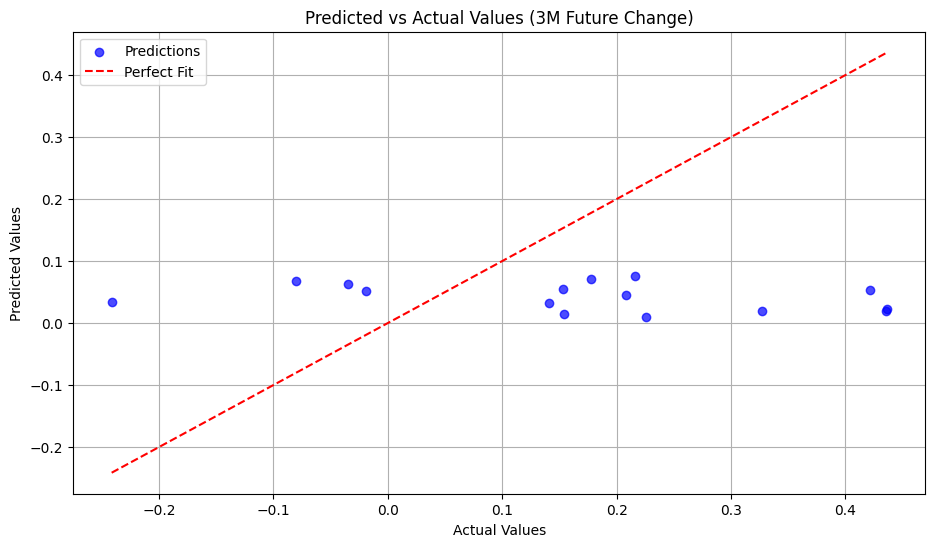

3M Future Change - R²: -0.5224
3M Future Change - MSE: 0.0554
3M Future Change - MAE: 0.2046

Overall Scores:
Mean - R²: -0.5224
Mean - MSE: 0.0554
Mean - MAE: 0.2046


In [12]:
if train_new_model:
    y_test_pred = model.predict(X_test)

    for i, target in enumerate(['3M Future Change']):
        y_test_actual = y_test[target].values
        if getattr(y_test_pred, "ndim", 1) == 1:
            y_test_pred_target = y_test_pred
        else:
            y_test_pred_target = y_test_pred[:, i]

        plt.figure(figsize=(11, 6))
        plt.scatter(y_test_actual, y_test_pred_target, alpha=0.7, color='blue', label='Predictions')
        plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 
            color='red', linestyle='--', label='Perfect Fit')
        plt.title(f'Predicted vs Actual Values ({target})')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.legend()
        plt.grid(True)
        plt.show()

        mae = mean_absolute_error(y_test_actual, y_test_pred_target)
        mse = mean_squared_error(y_test_actual, y_test_pred_target)
        r2 = r2_score(y_test_actual, y_test_pred_target)

        print(f'{target} - R²: {r2:.4f}')
        print(f'{target} - MSE: {mse:.4f}')
        print(f'{target} - MAE: {mae:.4f}')

    # Overall metrics (single target)
    overall_pred = y_test_pred if getattr(y_test_pred, "ndim", 1) == 1 else y_test_pred[:, 0]
    mae = mean_absolute_error(y_test['3M Future Change'].values, overall_pred)
    mse = mean_squared_error(y_test['3M Future Change'].values, overall_pred)
    r2 = r2_score(y_test['3M Future Change'].values, overall_pred)

    print('\nOverall Scores:')
    print(f'Mean - R²: {r2:.4f}')
    print(f'Mean - MSE: {mse:.4f}')
    print(f'Mean - MAE: {mae:.4f}')

### Log test results

In [13]:
if train_new_model:
    test_results = pd.DataFrame({
        'R²': r2,
        'MSE': mse,
        'MAE': mae,
        'symbol_list': symbol_list,
        "iterations": iterations,
        'hidden_layer_sizes': [model.model.hidden_layer_sizes],
        'max_iter': model.model.max_iter,
        'n_iter_no_change': model.model.n_iter_no_change,
        'learning_rate': model.model.learning_rate,
        'learning_rate_init': model.model.learning_rate_init,
        'batch_size': model.model.batch_size,
        'tol': model.model.tol,
        'alpha': model.model.alpha,
        'shuffle': model.model.shuffle,
    })
    test_results.to_csv('../data/model_results/test_results.csv', mode='a', index=False)

    # save model as new best if results are better than the current one
    best_r2 = pd.read_csv('../data/model_results/best_model_results.csv').loc[0, 'R²']
    if r2 > best_r2:
        print(f'Old best R²: {best_r2}')
        print(f'New best R²: {r2}')
        print('Saving new best model...')
        test_results.to_csv('../data/model_results/best_model_results.csv', mode='w', index=False)
        with open('../models/best_model.pkl','wb') as f:
            pickle.dump(model,f)
        

## Predictions on latest data

In [14]:
best_r2 = pd.read_csv('../data/model_results/best_model_results.csv').loc[0, 'R²']

with open('../models/best_model.pkl', 'rb') as f:
    model = pickle.load(f)
    print(f'Best model R²: {best_r2}')


FileNotFoundError: [Errno 2] No such file or directory: '../models/best_model.pkl'

In [ ]:
df_raw = pd.read_csv('../data/earnings_data.csv')

results = []
for i in range(len(X_pred)):
    y_pred = model.predict(X_pred.iloc[[i]])[0]
    y_pred_3m, y_pred_6m, y_pred_9m, y_pred_1y = y_pred
    avg = (y_pred_3m + y_pred_6m + y_pred_9m + y_pred_1y) / 4
    results.append({
        'Ticker': df_raw.loc[i*4, 'Ticker'],
        'Name': df_raw.loc[i*4, 'Name'],
        'mean (%)': avg * 100,
        '3m (%)': y_pred_3m * 100,
        '6m (%)': y_pred_6m * 100,
        '9m (%)': y_pred_9m * 100,
        '1y (%)': y_pred_1y * 100
    })

results_df = pd.DataFrame(results)
results_df

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Asset Turnover
- Book Value Per Share
- Current Ratio
- Days Sales In Receivables
- Debt\/Equity Ratio
- ...
Feature names seen at fit time, yet now missing:
- Accounts Payable
- Accounts Receivable
- Accrued Interest Receivable
- Accumulated Depreciation
- Additional Paid In Capital
- ...


In [ ]:
def predict_ticker(ticker_str):
    try:
        ticker_str = str(ticker_str).upper()
        ticker_str = ticker_str.replace("'", "")
        ticker_str = ticker_str.replace('"', "")
        row = results_df[results_df['Ticker'] == ticker_str]
        if row.empty:
            return (f"Not enough data for this stock at this moment \n Try another", "", "", "", "")
        row = row.iloc[0]
        return (
            f"{row['3m (%)']:.2f}",
            f"{row['6m (%)']:.2f}",
            f"{row['9m (%)']:.2f}",
            f"{row['1y (%)']:.2f}",
            f"{row['mean (%)']:.2f}",
        )
    except Exception as e:
        return (f"Error: {e}", "", "", "", "")

In [ ]:
iface = gr.Interface(
    fn=predict_ticker,
    inputs=gr.Textbox(label="Ticker e.g. 'TSLA' or 'NVDA'"),
    outputs=[
        gr.Textbox(label="3 Month Change Prediction (%)"),
        gr.Textbox(label="6 Month Change Prediction (%)"),
        gr.Textbox(label="9 Month Change Prediction (%)"),
        gr.Textbox(label="1 Year Change Prediction (%)"),
        gr.Textbox(label="Mean Change Prediction (%)"),
    ],
    title="Stock Price Prediction Model",
    description=" "
)

iface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://d6f7567b4876962a6e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
